In [52]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [ ]:
"""
dx/dt = alpha * (1 - x) - beta * x
beta * x + alpha * x = alpha
x = alpha / (alpha + beta)
"""

In [57]:
class HCN(nn.Module):
    def __init__(self):
        super(HCN, self).__init__()
        self.p = nn.Parameter(torch.tensor([0.00643, 154.9, 11.9, 0.193, 33.1]))

    def set_rate_parameters(self, V):
        alpha = self.p[0] * (V + self.p[1]) / (torch.exp((V + self.p[1]) / self.p[2]) - 1)
        beta = self.p[3] * torch.exp(V / self.p[4])
        return alpha, beta
    
    def forward(self, V, h):
        alpha, beta = self.set_rate_parameters(V)
        dh = alpha * (1 - h) - beta * h
        return dh

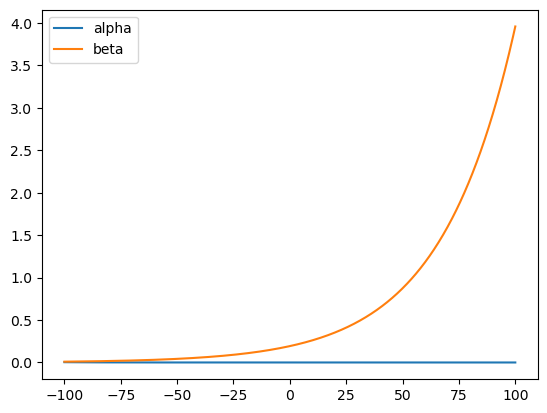

In [65]:
hcn = HCN()
V = torch.linspace(-100, 100, 1000)
alpha, beta = hcn.set_rate_parameters(V)
plt.plot(V, alpha.detach(), label='alpha')
plt.plot(V, beta.detach(), label='beta')
plt.legend()
plt.show()

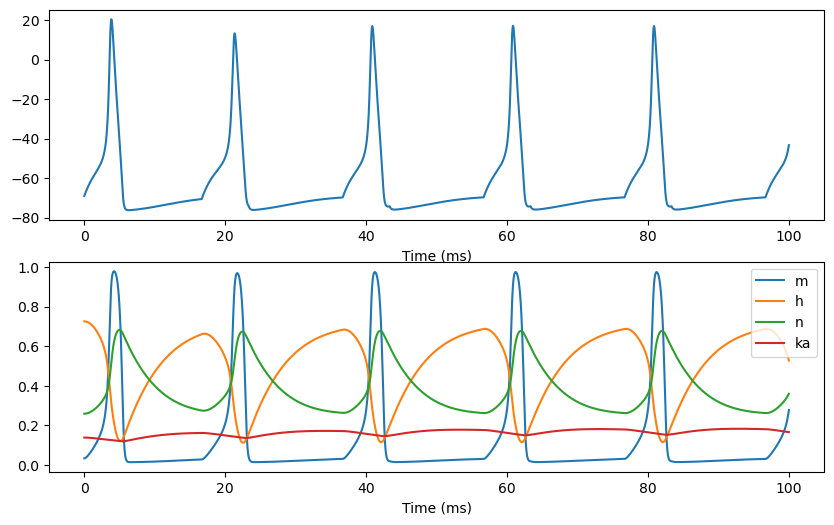

In [70]:
class HodgkinHuxleyNeuron(nn.Module):
    """
    https://neuronaldynamics.epfl.ch/online/Ch2.S2.html#Ch2.F6
    """
    def __init__(self, dt=None):
        super().__init__()
        # Conductances (mS/cm^2)
        self.g_Na = 40.0
        self.g_K = 35.0
        self.g_L = 0.3
        self.g_H = 1.0
        self.g_A = 4.262
        
        self.tau_A = 30

        # Reversal potentials (mV)
        self.E_Na = 55.0
        self.E_K = -77.0
        self.E_L = -65.0
        self.E_H = -45.0

        # Membrane capacitance (µF/cm^2)
        self.C_m = 1.0
        
        self.dt = dt or 0.001

    def get_initial_state(self, V):
        alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n, alpha_ka, beta_ka = self._set_gating_params(V)
        m = alpha_m / (alpha_m + beta_m)
        h = alpha_h / (alpha_h + beta_h)
        n = alpha_n / (alpha_n + beta_n)
        return m, h, n, beta_ka
    
    """
    alpha = a * (V + b) / (1 - exp(-c * (V + b)))
    beta = d * exp(-e * (V + f))
    """

    def _set_gating_params(self, V):
        # Gating variable rate constants
        alpha_m = 0.1 * (V + 40.0) / (1 - torch.exp(-0.1*(V + 40)))
        beta_m = 4 * torch.exp(-0.0556 * (V + 65.0))
        alpha_h = 0.07 * torch.exp(-0.05 * (V + 65))
        beta_h = 1 / (1 + torch.exp(-0.1*(V + 35)))
        alpha_n = 0.01 * (V + 55.0) / (1 - torch.exp(-0.1*(V+55.0)))
        beta_n = 0.125 * torch.exp(-0.0125 * (V + 65.0))
        alpha_ka = 1 / (torch.exp(-(V + 50) / 20) + 1)
        beta_ka = 1 / (torch.exp((V + 80) / 6) + 1)
        return alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n, alpha_ka, beta_ka
    
    def forward(self, V, m, h, n, ka, I):
        # Gating variable rate constants
        alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n, alpha_ka, beta_ka = self._set_gating_params(V)
        dm = alpha_m * (1 - m) - beta_m * m
        dh = alpha_h * (1 - h) - beta_h * h
        dn = alpha_n * (1 - n) - beta_n * n
        dbka = (beta_ka - ka) / self.tau_A
        m = m + dm * self.dt
        h = h + dh * self.dt
        n = n + dn * self.dt
        ka = ka + dbka * self.dt
        
        # Compute currents
        I_Na = self.g_Na * m**3 * h * (V - self.E_Na)
        I_K = self.g_K * n**4 * (V - self.E_K)
        I_L = self.g_L * (V - self.E_L)
        I_KA = self.g_A * alpha_ka**3 * ka * (V - self.E_K)
        
        # Compute membrane potential
        dV = (I - I_Na - I_K - I_L - I_KA) / self.C_m
        V = V + dV * self.dt
        return V, m, h, n, ka
    
# Simulation Parameters
model = HodgkinHuxleyNeuron(dt = 0.01)

V0 = -69.0
m0, h0, n0, ka0 = model.get_initial_state(torch.tensor(V0))

dt = model.dt
T = 100
NT = int(T//dt)
tt = torch.arange(NT) * dt

V = torch.zeros(NT)
m = torch.zeros(NT)
h = torch.zeros(NT)
n = torch.zeros(NT)
ka = torch.zeros(NT)

V[0] = V0
m[0] = m0
h[0] = h0
n[0] = n0
ka[0] = ka0

I = 10.0*((np.cos(2*np.pi*tt/20) - 0.5)>0)
for i in range(1, NT):
    Vi, mi, hi, ni, kai = model(V[i-1], m[i-1], h[i-1], n[i-1], ka[i-1], I[i])
    V[i] = Vi
    m[i] = mi
    h[i] = hi
    n[i] = ni
    ka[i] = kai

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(tt, V.detach())
ax[0].set_xlabel('Time (ms)')

ax[1].plot(tt, m.detach(), label='m')
ax[1].plot(tt, h.detach(), label='h')
ax[1].plot(tt, n.detach(), label='n')
ax[1].plot(tt, ka.detach(), label='ka')
ax[1].set_xlabel('Time (ms)')
ax[1].legend()

plt.show()

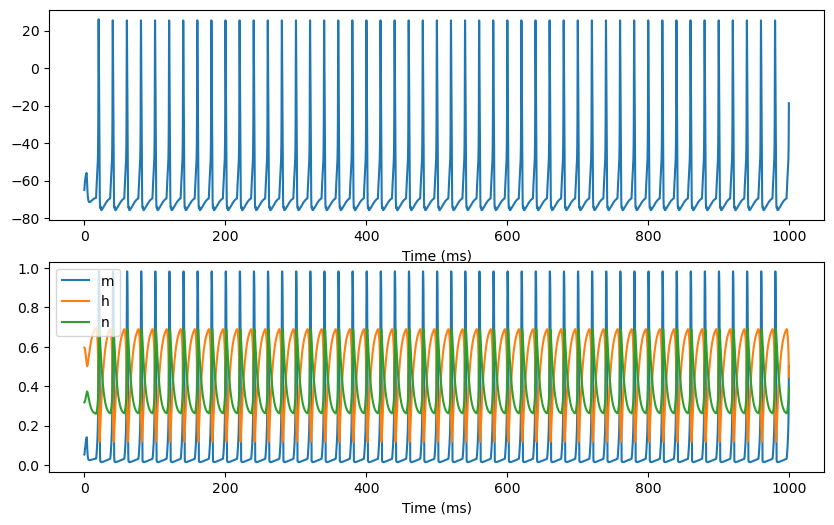

In [39]:
def get_m(V):
    alpha = 0.1 * (V + 40.0) / (1 - np.exp(-0.1*(V + 40)))
    beta = 4 * np.exp(-0.0556 * (V + 65.0))
    return alpha, beta

def get_h(V):
    alpha = 0.07 * np.exp(-0.05 * (V + 65))
    beta = 1 / (1 + np.exp(-0.1*(V + 35)))
    return alpha, beta

def get_n(V):
    alpha = 0.01 * (V + 55.0) / (1 - np.exp(-0.1*(V+55.0)))
    beta = 0.125 * np.exp(-0.0125 * (V + 65.0))
    return alpha, beta

# Model Parameters
g_Na = 40.0
g_K = 36.0
g_L = 0.3
E_Na = 55.0
E_K = -77.0
E_L = -65.0
C_m = 1.0

# Simulation Parameters
V0 = -65.0


alpha_m, beta_m = get_m(V0)
alpha_h, beta_h = get_h(V0)
alpha_n, beta_n = get_n(V0)

m0 = alpha_m / (alpha_m + beta_m)
h0 = alpha_h / (alpha_h + beta_h)
n0 = alpha_n / (alpha_n + beta_n)


dt = 0.01
T = 1000
NT = int(T//dt)
tt = np.arange(NT) * dt

V = np.zeros(NT)
m = np.zeros(NT)
h = np.zeros(NT)
n = np.zeros(NT)

V[0] = V0
m[0] = m0
h[0] = h0
n[0] = n0

I = 10.0*((np.cos(2*np.pi*tt/20) - 0.5)>0)
for i in range(1, NT):
    alpha_m, beta_m = get_m(V[i-1])
    alpha_h, beta_h = get_h(V[i-1])
    alpha_n, beta_n = get_n(V[i-1])

    dm = alpha_m * (1 - m[i-1]) - beta_m * m[i-1]
    dh = alpha_h * (1 - h[i-1]) - beta_h * h[i-1]
    dn = alpha_n * (1 - n[i-1]) - beta_n * n[i-1]

    m[i] = m[i-1] + dm * dt
    h[i] = h[i-1] + dh * dt
    n[i] = n[i-1] + dn * dt

    I_Na = g_Na * m[i]**3 * h[i] * (V[i-1] - E_Na)
    I_K = g_K * n[i]**4 * (V[i-1] - E_K)
    I_L = g_L * (V[i-1] - E_L)

    dV = (I[i] - I_Na - I_K - I_L) / C_m

    V[i] = V[i-1] + dV * dt

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(tt, V)
ax[0].set_xlabel('Time (ms)')

ax[1].plot(tt, m, label='m')
ax[1].plot(tt, h, label='h')
ax[1].plot(tt, n, label='n')
ax[1].set_xlabel('Time (ms)')
ax[1].legend()

plt.show()

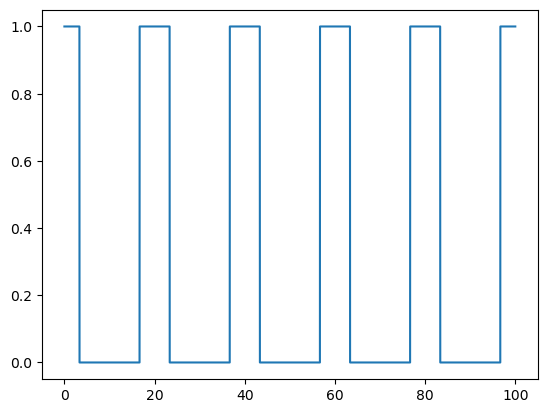

In [36]:
plt.plot(tt, 1*(np.cos(2*np.pi*tt/20) - 0.5)>0)

In [30]:
class HodgkinHuxleyNeuron(nn.Module):
    """
    https://neuronaldynamics.epfl.ch/online/Ch2.S2.html#Ch2.F6
    """
    def __init__(self):
        super().__init__()
        # Conductances (mS/cm^2)
        self.g_Na = 40.0
        self.g_K = 35.0
        self.g_L = 0.3
        
        # Reversal potentials (mV)
        self.E_Na = 55.0
        self.E_K = -77.0
        self.E_L = -65.0
        
        # Membrane capacitance (µF/cm^2)
        self.C_m = 1.0

        self.dt = 0.001

        self.set_initial_state()

    def set_initial_state(self, V=None):
        if V is None:
            self.V = self.E_L
        
        # Set initial state
        self._set_gating_params(self.V)
        self.m = self.alpha_m / (self.alpha_m + self.beta_m)
        self.h = self.alpha_h / (self.alpha_h + self.beta_h)
        self.n = self.alpha_n / (self.alpha_n + self.beta_n)

    def _set_gating_params(self, V):
        # Gating variable rate constants
        self.alpha_m = 0.182 * (V + 35) / (1 - np.exp(-(V+35)/9))
        self.beta_m = -0.124 * (V + 35) / (1 - np.exp((V+35)/9))
        self.alpha_h = 0.25 * np.exp(-(V + 90) / 12)
        self.beta_h = 0.25 * np.exp((V+62)/6)/np.exp((V+90)/12)
        self.alpha_n = 0.02 * (V - 25) / (1 - np.exp(-(V-25)/9))
        self.beta_n = -0.002 * (V - 25) / (1 - np.exp(-(V-25)/9))
    
    def _update_gating_params(self, n, m, h):
        dm = self.alpha_m * (1 - m) - self.beta_m * m
        dh = self.alpha_h * (1 - h) - self.beta_h * h
        dn = self.alpha_n * (1 - n) - self.beta_n * n
        return dm, dh, dn
    
    def forward(self, dt=None, I_ext=0, V=None, m=None, h=None, n=None):
        # Gating variable rate constants
        V = V or self.V
        self._set_gating_params(V)
        m = m or self.m
        h = h or self.h
        n = n or self.n
        dm, dh, dn = self._update_gating_params(n, m, h)
        self.m = self.m + dm * self.dt
        self.h = self.h + dh * self.dt
        self.n = self.n + dn * self.dt
        
        # Compute currents
        I_Na = self.g_Na * m**3 * h * (V - self.E_Na)
        I_K = self.g_K * n**4 * (V - self.E_K)
        I_L = self.g_L * (V - self.E_L)
        
        # Compute membrane potential
        dV = (I_ext - I_Na - I_K - I_L) / self.C_m
        self.V = V + dV * self.dt
        return V

model = HodgkinHuxleyNeuron()

T = 20  # Total simulation time (ms)
dt = 0.1  # Time step (ms)
NT = int(T//dt) # Number of time steps
I_ext = 10000.0  # External current for neuron 1 (µA/cm^2)

V = model.E_L * torch.ones(NT)  # Membrane potential (mV)
for i in range(1, NT):
    V[i] = model(I_ext=I_ext)

plt.plot(V)

/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_14085/1480548537.py:36: RuntimeWarning: overflow encountered in exp
  self.alpha_m = 0.182 * (V + 35) / (1 - np.exp(-(V+35)/9))
/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_14085/1480548537.py:38: RuntimeWarning: overflow encountered in exp
  self.alpha_h = 0.25 * np.exp(-(V + 90) / 12)
/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_14085/1480548537.py:39: RuntimeWarning: invalid value encountered in scalar divide
  self.beta_h = 0.25 * np.exp((V+62)/6)/np.exp((V+90)/12)
/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_14085/1480548537.py:40: RuntimeWarning: overflow encountered in exp
  self.alpha_n = 0.02 * (V - 25) / (1 - np.exp(-(V-25)/9))
/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_14085/1480548537.py:41: RuntimeWarning: overflow encountered in exp
  self.beta_n = -0.002 * (V - 25) / (1 - np.exp(-(V-25)/9))
/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_14085/1

RuntimeError: value cannot be converted to type float without overflow

In [17]:
NT

199.0